# Generate/Reconstruct

This script is to generate or reconstruct the data using the trained VideoVAE model.

Designed to easily swap between version

In [1]:
import os
import json
import torch
import imageio
import numpy as np
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
version = "v10.02"
save_dir = f"/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_{version}"
os.chdir(f"{save_dir}")

with open("model_config.json", "r") as f:
  config = json.load(f)

latent_dim = config["latent_dim"]
hidden_dims = config["hidden_dims"]

from utils import get_data_loaders
from model_architecture import VideoVAE
from VideoDataset import VideoDataset


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VideoVAE(3, latent_dim=latent_dim, hidden_dims=hidden_dims).to(device)

model_path = save_dir + '/video_vae_final.pth'

checkpoint = torch.load(model_path, map_location=device)

model.load_state_dict(checkpoint)

model.eval()

VideoVAE(
  (encoder_block1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_block2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_block3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_block4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=

In [7]:
video_data_path = '/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/processed_data/video_data-9frame-v1.0.npy'
# video_data_path = '/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/processed_data/video_data-9frame-v2.0.npy'
video_data = np.load(video_data_path, allow_pickle=True)
dataset = VideoDataset(video_data)

In [8]:
sample = dataset[0]
print(sample.shape)

torch.Size([3, 9, 128, 128])


# Reconstruct videos (NPY dataset required)

In [9]:
import os
import torch
import numpy as np
import imageio
from concurrent.futures import ThreadPoolExecutor

def write_frame(frame, frame_path):
    imageio.imwrite(frame_path, frame)

def generate_frames(model, dataset, device, save_dir, num_reconstructions=10):
    videos_dir = os.path.join(save_dir, "videos")
    reconstructions_path = os.path.join(videos_dir, "reconstructions")
    os.makedirs(reconstructions_path, exist_ok=True)
    print(f"reconstructions_path created: ", reconstructions_path)

    model.eval()
    with torch.no_grad():
        # ----------------------- Reconstructed Frames ----------------------- #
        for i in range(num_reconstructions):
            video_dir = os.path.join(reconstructions_path, f"reconstructed_video_{i+1}")
            os.makedirs(video_dir, exist_ok=True)

            sample_vid = dataset[i]  # shape: (C, T, H, W)
            sample_vid = sample_vid.unsqueeze(0).to(device)

            reconstruction, _, _ = model(sample_vid)
            reconstruction = reconstruction[0].cpu()
            recon_np = reconstruction.permute(1, 2, 3, 0).numpy()
            recon_np_uint8 = (recon_np * 255).clip(0, 255).astype(np.uint8)

            num_frames = recon_np_uint8.shape[0]
            # Use thread pool to save frames concurrently
            with ThreadPoolExecutor() as executor:
                for frame_idx in range(num_frames):
                    frame = recon_np_uint8[frame_idx]
                    frame_path = os.path.join(video_dir, f"frame_{frame_idx+1:03d}.png")
                    executor.submit(write_frame, frame, frame_path)
            print(f"Saved reconstructed video {i+1} frames to {video_dir}")

    print(f"Frame data has been saved to {videos_dir}")


In [10]:
len(dataset)

632

In [11]:
generate_frames(model, dataset, device, save_dir, num_reconstructions=632)

reconstructions_path created:  /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2
Saved reconstructed video 1 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2/reconstructed_video_1
Saved reconstructed video 2 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2/reconstructed_video_2
Saved reconstructed video 3 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2/reconstructed_video_3
Saved reconstructed video 4 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2/reconstructed_video_4
Saved reconstructed video 5 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.00/videos/reconstructions2/reconstructed_video_5
Saved reconstructed video 6 frames to /

# Generate Samples

In [12]:
import os
import numpy as np
import torch
import imageio
from concurrent.futures import ThreadPoolExecutor

def write_frame(frame, frame_path):
    imageio.imwrite(frame_path, frame)

def generate_samples(model, device, save_dir, num_samples=10):
    """
    Generate new video samples from the VAE's latent space and save each samples frames as images.

    Args:
        model: The trained VideoVAE model.
        device: The device on which the model is running.
        save_dir: Directory where the video frames will be saved.
        num_samples: Number of new sample videos to generate.
    """
    videos_dir = os.path.join(save_dir, "videos")
    samples_path = os.path.join(videos_dir, "generated_samples")
    os.makedirs(samples_path, exist_ok=True)
    print("samples_path created:", samples_path)

    model.eval()
    with torch.no_grad():
        # ----------------------- Generated Video Frames ----------------------- #
        for i in range(num_samples):
            video_dir = os.path.join(samples_path, f"sample_video_{i+1}")
            os.makedirs(video_dir, exist_ok=True)

            # Generate a new video sample from the VAE latent space.
            sample_vid = model.sample(1, device)  # Shape: (1, 3, 9, 128, 128)
            sample_vid = sample_vid[0].cpu()        # Shape: (3, 9, 128, 128)
            # Permute to shape (T, H, W, C) for proper image saving.
            sample_np = sample_vid.permute(1, 2, 3, 0).numpy()
            sample_np_uint8 = (sample_np * 255).clip(0, 255).astype(np.uint8)

            num_frames = sample_np_uint8.shape[0]
            # Use a thread pool to save frames concurrently.
            with ThreadPoolExecutor() as executor:
                for frame_idx in range(num_frames):
                    frame = sample_np_uint8[frame_idx]
                    frame_path = os.path.join(video_dir, f"frame_{frame_idx+1:03d}.png")
                    executor.submit(write_frame, frame, frame_path)
            print(f"Saved sample video {i+1} frames to {video_dir}")

    print(f"Sample video frames have been saved to {videos_dir}")


In [13]:
generate_samples(model, device, save_dir, num_samples=10)

samples_path created: /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples
Saved sample video 1 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_1
Saved sample video 2 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_2
Saved sample video 3 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_3
Saved sample video 4 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_4
Saved sample video 5 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_5
Saved sample video 6 frames to /content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/

In [28]:
import os
import imageio
from IPython.display import Image, display

def create_gif_from_frames(video_dir, output_file='video.gif', duration=0.1):
    """
    Create a GIF from a sequence of PNG frames stored in a directory.

    Args:
        video_dir (str): Path to the directory containing frame images.
        output_file (str): Filename to save the resulting GIF.
        duration (float): Time duration (in seconds) for each frame.

    Returns:
        str: The path to the created GIF file.
    """
    frame_files = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.png')])

    if not frame_files:
        print(f"No PNG files found in {video_dir}")
        return None

    frames = []
    for file in frame_files:
        frame = imageio.imread(file)
        frames.append(frame)

    # Write frames to a gif file.
    imageio.mimwrite(output_file, frames, duration=duration, loop=0)
    print("Created GIF:", output_file)
    return output_file


# Visualise

<ipython-input-28-2ccaf4146f44>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(file)


Created GIF: sample.gif


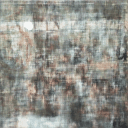

In [31]:
video_dir = "/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/trained_models/vae_model_v10.02/videos/generated_samples/sample_video_2"

# Create the GIF file.
output_gif_path = "sample.gif"
gif_file = create_gif_from_frames(video_dir, output_file=output_gif_path, duration=1)

display(Image(filename=gif_file))